In [1]:
#meadow area vs area with changes to vels / ero-dep
from netCDF4 import Dataset
import numpy as  np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from datetime import datetime
from shapely.geometry import Polygon, LineString

import math
import glob
import os.path
import sys
sys.path.insert(0, '/home/g/g260204/tools/python_skripts/SchismUtils/')
from schism_utils import read_data, sort_files
import h5py
import os.path

from matplotlib import rcParams
rcParams['figure.dpi'] = 300

import matplotlib as mpl
mpl.rc('hatch', color='k', linewidth=1)

In [2]:
#input
sims =  ['srm020','srm026','srm024']
labels = ['no sg','stat sg [ref]','var sg [ref]','stat sg [int]','var sg [int]']
simpat = '/work/gg0877/g260204/sim_data/SR5yr/'
seasons = ['mar','aug']
mons = [3,8]
dy = 0.01
dx = dy/np.cos(math.radians(55))
outpath = '/work/gg0877/g260204/sim_data/SR5yr/plots/plots/srm02x/'

if not os.path.exists(outpath):
    os.makedirs(outpath)

In [3]:
#functions
def get_vels(sim,season):
    v = np.zeros(48883)
    n = 0

    for year in range(2010,2016):
        simname = f'{sim}_{year}'
        hdf5file = '/work/gg0877/g260204/data/pickle_files/' +simname + '_mean_vel_bot_'+season+'.hdf5'
    
        if os.path.isfile(hdf5file):    
            #print('read from file:', simname)
            f = h5py.File(hdf5file,'r')
            v += np.sqrt(f['x_mean'][:]**2+f['y_mean'][:]**2)
            n += 1
            f.close()
        else:
           print(f'no hdf5 file for {simname} {season}')
    
    v = v/n
   
    return v

def get_depth(sim,simpat,mon):
    doy = datetime(2010,mon,1).timetuple().tm_yday
    dch  = np.zeros(48883)
    n = 0
    
    for year in range(2010,2016):
        simname = f'{sim}_{year}'
        ncpat_s = f'{simpat}{simname}/outputs/schout_{doy}.nc'
        ncpat_e = f'{simpat}{simname}/outputs/schout_{doy+30}.nc'

        
        #read data1
        ncdata_s = Dataset(ncpat_s,mode='r')
        ncdata_e = Dataset(ncpat_e,mode='r')
        start = ncdata_s.variables['SED_depth_change'][-1,:]
        end = ncdata_e.variables['SED_depth_change'][-1,:]
        dch += end-start
        n += 1
        

    dch = dch/n
    return dch

def get_sg(boundary_coords,patches,A):
    geometries = []
    
    for coords in boundary_coords:
        if len(coords) > 2 and np.all(coords[0] == coords[-1]):
            # If the first and last points are the same, it's a closed loop -> Polygon
            polygon = Polygon(coords)
            geometries.append(polygon)
        else:
            # Otherwise, it's an open boundary -> LineString
            line = LineString(coords)
            geometries.append(line)

    areas = []
    #calculate areas:
    for patch in patches:
        areas.append(np.nansum(A[patch]))
    # Create a GeoDataFrame with the boundary geometries
    gdf = gpd.GeoDataFrame(geometry=geometries)
    gdf['area']=areas
    return gdf

def center(geo):
    #bnd = geo.geometry.total_bounds
    bnd = geo.geometry.bounds
    return [(bnd[2]+bnd[0])/2 ,(bnd[1]+bnd[3])/2]

def p_in_square(points,xmin,xmax,ymin,ymax):
    indices = []
    for i, (x,y) in enumerate(points):
        if xmin <= x <= xmax and ymin <= y <= ymax:
            indices.append(i)
    return indices

def element_area(x,y,tri):
    #convert x,y from lat, lon to meters. use min(x),min(y) as reference x -> lon, y = lat
    #approximation is enough: 1deg lat = 111.319 km; 1 deg lon = 111.319 km * cos(phi)
    r_earth = 40075000 #m
    x = (x-min(x))*r_earth/360*np.cos(math.radians(np.mean(y)))
    y = (y-min(y))*r_earth/360
    
    tri_x = x[tri]
    tri_y = y[tri]
    tri_y_c = np.mean(tri_y,1)
    
    A = 0.5*(np.multiply(tri_x[:, 0], (tri_y[:, 1]-tri_y[:, 2]))
             + np.multiply(tri_x[:, 1], (tri_y[:, 2]-tri_y[:, 0]))
             + np.multiply(tri_x[:, 2], (tri_y[:, 0]-tri_y[:, 1])))
    #maks area inside basin
    hdf5pat = '/work/gg0877/g260204/data/pickle_files/mask_basin.hdf5'
    f = h5py.File(hdf5pat,'r')
    nin = f['nin'][:]
    nintri = np.floor(np.sum(nin[tri],1)/3)
    A[nintri==1] = np.nan
    return A #m2

def haversine(point1, point2):
    import math

    # Coordinates in decimal degrees (e.g. 2.89078, 12.79797)
    lon1, lat1 = point1
    lon2, lat2 = point2

    R = 6371000  # radius of Earth in meters
    phi_1 = math.radians(lat1)
    phi_2 = math.radians(lat2)

    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi / 2.0) ** 2 + math.cos(phi_1) * math.cos(phi_2) * math.sin(delta_lambda / 2.0) ** 2    
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    meters = R * c  # output distance in meters
    #km = meters / 1000.0  # output distance in kilometers
    return meters

def find_closest(point,point_list):
    dist = 9999999
    for p in point_list:
        d = haversine(point,p)
        if d < dist and d > 0:
            dist = d
    return dist

In [4]:
#find meadows in patchsav
from collections import defaultdict

def find_cluster_boundary_and_patches(x, y, tri, patch):
    # Step 1: Filter triangles where patch is 1
    triangles_in_cluster = tri[patch == 1]
    triangle_indices_in_cluster = np.where(patch == 1)[0]  # Indices of triangles where patch == 1
    
    # Step 2: Collect all edges of the selected triangles
    edges = []
    for i, triangle in enumerate(triangles_in_cluster):
        edges.append((triangle[0], triangle[1], i))
        edges.append((triangle[1], triangle[2], i))
        edges.append((triangle[2], triangle[0], i))
    
    # Step 3: Find boundary edges (those that appear only once)
    boundary_edges_dict = defaultdict(list)
    for edge in edges:
        a, idx = sorted([edge[0], edge[1]]), edge[2]
        boundary_edges_dict[tuple(a)].append(idx)
    
    boundary_edges = []
    for edge, idx_list in boundary_edges_dict.items():
        if len(idx_list) == 1:  # Edge belongs to only one triangle
            boundary_edges.append(edge)
    
    # Step 4: Build a graph for boundary connectivity (for cluster separation)
    graph = defaultdict(list)
    for edge in boundary_edges:
        graph[edge[0]].append(edge[1])
        graph[edge[1]].append(edge[0])
    
    # Step 5: Use DFS to find connected components of the boundary
    def find_connected_components(graph):
        visited = set()
        clusters = []
        
        def dfs(node):
            stack = [node]
            component = []
            while stack:
                current = stack.pop()
                if current not in visited:
                    visited.add(current)
                    component.append(current)
                    for neighbor in graph[current]:
                        if neighbor not in visited:
                            stack.append(neighbor)
            return component
        
        for node in graph:
            if node not in visited:
                clusters.append(dfs(node))
        return clusters
    
    boundary_clusters = find_connected_components(graph)
    
    # Step 6: Get the triangles corresponding to each cluster (boundary and interior)
    cluster_patches = []
    for boundary_cluster in boundary_clusters:
        # Collect all points in the boundary cluster
        boundary_points = set(boundary_cluster)
        
        # Step 7: Expand to include all triangles connected to the boundary
        visited_triangles = set()
        def expand_cluster_from_boundary():
            # Use DFS to traverse all triangles connected to boundary points
            stack = list(boundary_points)
            cluster_triangles = set()
            
            while stack:
                point = stack.pop()
                for i, triangle in enumerate(triangles_in_cluster):
                    if i in visited_triangles:
                        continue
                    # Check if this triangle contains the current boundary point
                    if any(vertex == point for vertex in triangle):
                        visited_triangles.add(i)
                        cluster_triangles.add(i)
                        # Add all its vertices to the stack for further exploration
                        stack.extend(triangle)
            return cluster_triangles
        
        # Get the indices of all triangles in the current cluster
        all_cluster_triangles = expand_cluster_from_boundary()
        
        # Map the triangle indices to the original `patch` indices
        cluster_patch_indices = triangle_indices_in_cluster[list(all_cluster_triangles)]
        cluster_patches.append(cluster_patch_indices)
    
    # Step 8: Extract the x, y coordinates for each cluster's boundary
    boundary_coords = []
    for boundary_cluster in boundary_clusters:
        boundary_cluster.append(boundary_cluster[0])
        coords = np.array([x[boundary_cluster], y[boundary_cluster]]).T
        boundary_coords.append(coords)
    
    return boundary_coords, cluster_patches



In [5]:
#read time independent data
ncdata = Dataset(f'{simpat}{sims[0]}_2010/outputs/schout_1.nc',mode='r')
x       = ncdata.variables['SCHISM_hgrid_node_x'][:]
y       = ncdata.variables['SCHISM_hgrid_node_y'][:]
x_f     = ncdata.variables['SCHISM_hgrid_face_x'][:]
y_f     = ncdata.variables['SCHISM_hgrid_face_y'][:]
tri     = ncdata.variables['SCHISM_hgrid_face_nodes'][:,:3]-1
A       = element_area(x,y,tri) #m2

#read patchsav
patchsav = np.loadtxt(f'{simpat}{sims[2]}_2010/patchsav.prop')[:,1]

boundary, patches = find_cluster_boundary_and_patches(x,y,tri,patchsav)

#get position and sizes of seagrass meadows:
sg = get_sg(boundary,patches,A)
#meadows = sg['name'].unique().tolist()
#centers = [center(sg[sg['name']==m]) for m in meadows]
#areas = [np.sum(sg.loc[sg['name']==m,'area']) for m in meadows]
centers = [center(sg.iloc[s]) for s in range(len(sg))]


In [6]:
#for each meadow, find which nodes are in surrounding square & how far nearest center is
#fig,axs = plt.subplots()
#sg.plot(ax=axs)
in_cdx = []
in_cda = []
closest_meadow = []
for c in centers:
    xmin,xmax,ymin,ymax = [c[0]-dx,c[0]+dx,c[1]-dx,c[1]+dx]
    in_cdx.append(p_in_square(zip(x,y),xmin,xmax,ymin,ymax))
    in_cda.append(p_in_square(zip(x_f,y_f),xmin,xmax,ymin,ymax))
    closest_meadow.append(find_closest(c,centers))
    #import matplotlib.patches as patches
    #square = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
    #axs.add_patch(square)

/tmp/ipykernel_2824191/1679122719.py:16: RuntimeWarning: invalid value encountered in divide
  delta = -(dch-dch_nosg)/abs(dch_nosg)*100
/tmp/ipykernel_2824191/1679122719.py:16: RuntimeWarning: divide by zero encountered in divide
  delta = -(dch-dch_nosg)/abs(dch_nosg)*100


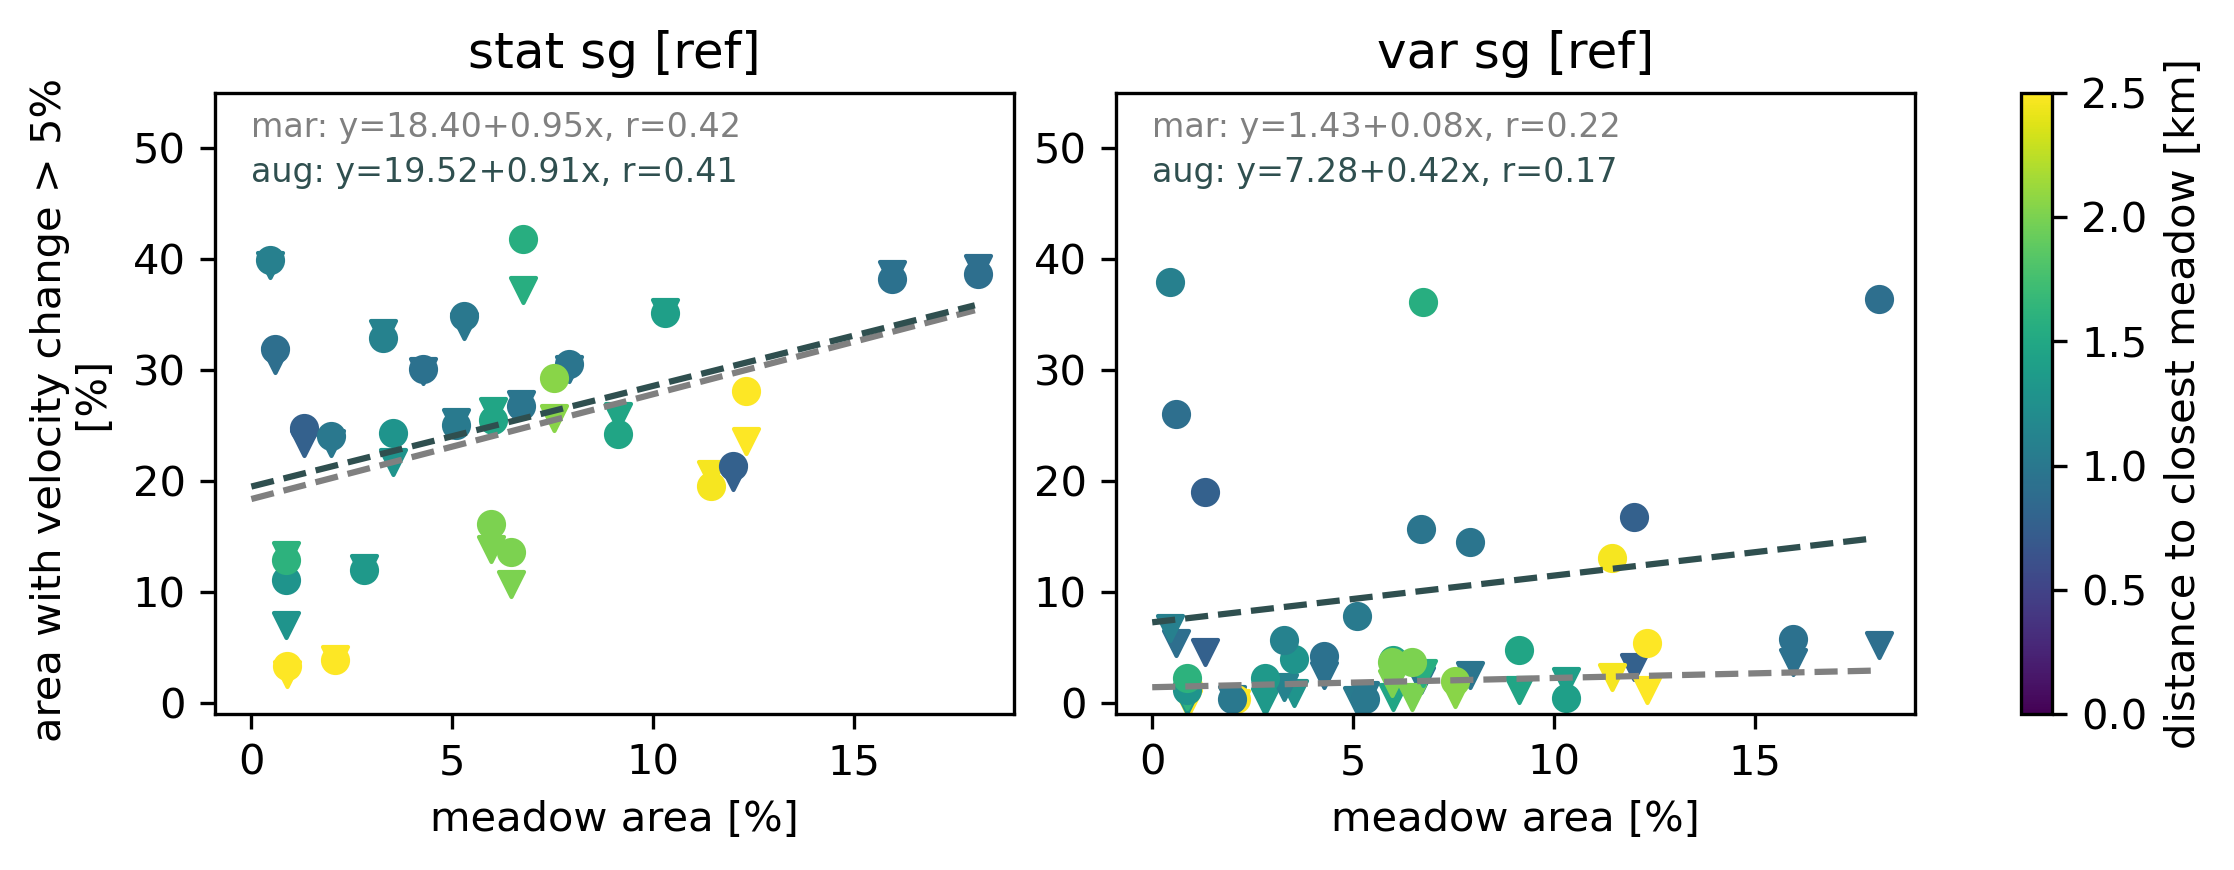

In [13]:
import scipy
fig, axes    = plt.subplots(nrows=1, ncols=2, figsize=(8,3))
axes         = axes.flatten()
markers = ['v','o']
colors = ['grey','darkslategray']

all_amead = np.zeros([len(mons),len(sims),len(centers)])
all_adch = np.zeros(np.shape(all_amead))
all_cmeadow = np.zeros(np.shape(all_amead))

for m in range(len(mons)):
    dch_nosg = get_vels(sims[0],seasons[m])
    for i in range(len(sims)-1):
        ir = i+1 # for runs bc first is reference
        dch = get_vels(sims[ir],seasons[m])
        delta = -(dch-dch_nosg)/abs(dch_nosg)*100
        delta[~np.isfinite(delta)] = 0 # remove errors from deviding by 0
        for im in range(len(centers)):
            tmp = delta[in_cdx[im]]
            tmp_a = A[in_cda[im]]
            n = np.where(abs(tmp)>5)
            totA = np.nansum(tmp_a)
            dchA = np.nansum(tmp_a[n])
            all_cmeadow[m,i,im] = closest_meadow[im]/1000
            ax1 = axes[i].scatter(sg.iloc[im]['area']/totA*100,dchA/totA*100,c=closest_meadow[im]/1000,
                            marker = markers[m],cmap='viridis',vmin = 0, vmax = 2.5)
            #axes[i].text(sg.iloc[im]['area']/totA*100,dchA/totA*100, f'{im}', color='red', fontsize=5)
            all_amead[m,i,im]= sg.iloc[im]['area']/totA*100
            all_adch[m,i,im] = dchA/totA*100
        slope, intercept, r, p, stderr = scipy.stats.linregress(all_amead[m,i,:],all_adch[m,i,:])
        regression_line = slope*np.array([0,18])+intercept
        axes[i].plot([0,18],regression_line,'--',color=colors[m])
        axes[i].text(0,51-4*m,f'{seasons[m]}: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}',fontsize=8,color=colors[m])
        axes[i].set_title(labels[ir])  
        axes[i].set_title(labels[ir])  
        axes[i].set_ylim([-1,55])
        axes[i].set_xlabel('meadow area [%]')
axes[0].set_ylabel('area with velocity change > 5% \n [%]')
plt.tight_layout()
fig.colorbar(ax1,ax=axes,orientation='vertical',label='distance to closest meadow [km]')
plt.savefig(f'{outpath}vel_meadow_area_patchsav_rel_dy{dy}.png')

In [14]:
import pandas as pd

for m in range(len(mons)):
    for i in range(len(sims)-1):
        ir = i+1 # for runs bc first is reference
        # Convert variables to a DataFrame
        df = pd.DataFrame({
            'meadow area': all_amead[m,i,:].flatten(),
            'dch area': all_adch[m,i,:].flatten(),
            'closest meadow': all_cmeadow[m,i,:].flatten()
        })
        
        # Compute the correlation matrix
        correlation_matrix = df.corr()
        
        print("Correlation Matrix: "+seasons[m]+' '+labels[ir])
        print(correlation_matrix)

Correlation Matrix: mar stat sg [ref]
                meadow area  dch area  closest meadow
meadow area        1.000000  0.422860       -0.020449
dch area           0.422860  1.000000       -0.584391
closest meadow    -0.020449 -0.584391        1.000000
Correlation Matrix: mar var sg [ref]
                meadow area  dch area  closest meadow
meadow area        1.000000  0.217302       -0.020449
dch area           0.217302  1.000000       -0.456924
closest meadow    -0.020449 -0.456924        1.000000
Correlation Matrix: aug stat sg [ref]
                meadow area  dch area  closest meadow
meadow area        1.000000  0.411434       -0.020449
dch area           0.411434  1.000000       -0.549802
closest meadow    -0.020449 -0.549802        1.000000
Correlation Matrix: aug var sg [ref]
                meadow area  dch area  closest meadow
meadow area        1.000000  0.173193       -0.020449
dch area           0.173193  1.000000       -0.332718
closest meadow    -0.020449 -0.332718   

2.4691358024691357